In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
from IPython import display
import gymnasium as gym
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter


# Setting cuda as the default device
torch.set_default_device("cuda")
# Enable live plotting
plt.ion()

# CNN Construction

For a given image of size $W \times W (square)$, stride $S$, filter (kernal) size $F \times F $, padding $P$, the output size of a convolutional operation will be an image of $W'\times W'$ where,
$$      W' = \frac{W-F+2P}{S} + 1  $$

From the google deepmind's paper, each image in an atari game has size $ 84 \times 84 \times 1 $. Therefore, the convolutional output of first, second, and third layer with kernal sizes $8\times8, 4\times4, 3\times3$ and depths 32, 64, and 64 are as follows,
$$ W_1 = \frac{84-8+0}{4} + 1 = 20 $$
$$ W_2 = \frac{20-4+0}{2} + 1 = 9 $$
$$ W_3 = \frac{9-3+0}{1} + 1 = 7 $$

Hence, we have the input of the first fully connected layer as $64 \times 7 \times 7 = 3136$ because the 3rd convolutional layer has depth 7.

In [2]:
# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(), # output size = (84-8+0)/4 + 1 = 20
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(), # output size = (20-4+0)/2+1 = 9
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(), # output size = (9-3+0)/1 + 1 = 7
            nn.Flatten(),
            nn.Linear(3136, 512), # input size = 64 * 7 * 7 = 3136
            nn.ReLU(),
            nn.Linear(512, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x / 255.0)

# Set device for running experiments
device = "cuda"

# Explaining the preprocessing steps

In [4]:
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk(): # Thunk is "a piece of code that does some delayed work"
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        """
        Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.

        :param env: Environment to wrap
        :param noop_max: Maximum value of no-ops to run
        """
        env = NoopResetEnv(env, noop_max=30) 
        """
        Return only every ``skip``-th frame (frameskipping)
        and return the max between the two last frames.

        :param env: Environment to wrap
        :param skip: Number of ``skip``-th frame
            The same action will be taken ``skip`` times.
        """
        env = MaxAndSkipEnv(env, skip=4)
        """
        Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.

        :param env: Environment to wrap
        """
        env = EpisodicLifeEnv(env)
        """
        Take action on reset for environments that are fixed until firing.

        :param env: Environment to wrap
        """
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        """
        Clip the reward to {+1, 0, -1} by its sign.

        :param env: Environment to wrap
        """
        env = ClipRewardEnv(env)
        # Resize the observation into 84 x 84 image
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        # Make RGB image into grayscale image
        env = gym.wrappers.GrayScaleObservation(env)
        # Stack every 4 frames together
        env = gym.wrappers.FrameStack(env, 4)
        env.action_space.seed(seed)
        return env
    return thunk

In [5]:
from dataclasses import dataclass

# HYPERPARAMETERS
@dataclass
class Args:
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""
    save_model: bool = False
    """whether to save model into the `runs/{run_name}` folder"""

    # Algorithm specific arguments
    env_id: str = "ALE/Assault-v5"
    """the id of the environment"""
    total_timesteps: int = 400000
    """total timesteps of the experiments"""
    learning_rate: float = 1e-4
    """the learning rate of the optimizer"""
    num_envs: int = 1 # TESTTTTTTTTTTTTTT
    """the number of parallel game environments"""
    buffer_size: int = 100000
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 1.0
    """the target network update rate"""
    target_network_frequency: int = 1000
    """the timesteps it takes to update the target network"""
    batch_size: int = 32
    """the batch size of sample from the reply memory"""
    start_e: float = 1
    """the starting epsilon for exploration"""
    end_e: float = 0.01
    """the ending epsilon for exploration"""
    exploration_fraction: float = 0.10
    """the fraction of `total-timesteps` it takes from start-e to go end-e"""
    learning_starts: int = 80000
    """timestep to start learning"""
    train_frequency: int = 4
    """the frequency of training"""

In [6]:
# Linear schedule for updating epsilon
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [7]:
args = Args() # Get the hyperparameters from the dataclass
assert args.num_envs == 1, "vectorized envs are not supported at the moment" # ONLY ONE ENV IS CURRENTLY SUPPORTING

# Writing summary to tensorboard
writer = SummaryWriter(f"runs/1")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

In [8]:
# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [9]:
args.env_id

'ALE/Assault-v5'

In [10]:
# env setup
envs = gym.vector.SyncVectorEnv(
    [make_env(args.env_id, args.seed + i, i, args.capture_video, '1') for i in range(args.num_envs)]
)
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"
# # Deep Q learning only supports discrete action space

In [11]:
q_network = QNetwork(envs).to(device)
target_network = QNetwork(envs).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = torch.optim.Adam(q_network.parameters(), lr=args.learning_rate)

rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    optimize_memory_usage=True,
    handle_timeout_termination=False,
)

In [12]:
import matplotlib.pyplot as plt
from IPython import display
plt.ion()

# Make a function for plotting average reward and loss
def plot_results(avg_reward_list):
    # plt.figure(1)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Average reward')
    plt.plot(avg_reward_list)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [13]:
avg_reward_list = []
# TRY NOT TO MODIFY: start the game
obs, _ = envs.reset(seed=args.seed)
for global_step in range(args.total_timesteps):
    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        q_values = q_network(torch.Tensor(obs).to(device))
        actions = torch.argmax(q_values, dim=1).cpu().numpy()

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    if "final_info" in infos:
        for info in infos["final_info"]:
            if info and "episode" in info:
                episodic_return = info['episode']['r']
                avg_reward_list.append(episodic_return)                
                # plot_results(avg_reward_list)
                print(f"global_step={global_step}/{args.total_timesteps}, episodic_return={episodic_return} complete={int((global_step/args.total_timesteps)*100)} %")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    for idx, trunc in enumerate(truncations):
        if trunc:
            real_next_obs[idx] = infos["final_observation"][idx]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        if global_step % args.train_frequency == 0:
            data = rb.sample(args.batch_size)
            with torch.no_grad():
                target_max, _ = target_network(data.next_observations).max(dim=1)
                td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())
            old_val = q_network(data.observations).gather(1, data.actions).squeeze()
            criterion = torch.nn.SmoothL1Loss()
            loss = criterion(td_target, old_val)

            if global_step % 100 == 0:
                writer.add_scalar("losses/td_loss", loss, global_step)
                writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                # print("SPS:", int(global_step / (time.time() - start_time)))

            # optimize the model
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(q_network.parameters(), 100) # In-place gradient clipping
            optimizer.step()

        # update target network
        if global_step % args.target_network_frequency == 0:
            for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                target_network_param.data.copy_(
                    args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
                )
envs.close()
writer.close()

global_step=111/400000, episodic_return=[63.] complete=0 %
global_step=303/400000, episodic_return=[210.] complete=0 %
global_step=567/400000, episodic_return=[189.] complete=0 %
global_step=827/400000, episodic_return=[294.] complete=0 %
global_step=1008/400000, episodic_return=[189.] complete=0 %
global_step=1196/400000, episodic_return=[189.] complete=0 %
global_step=1342/400000, episodic_return=[105.] complete=0 %
global_step=1525/400000, episodic_return=[189.] complete=0 %
global_step=1804/400000, episodic_return=[210.] complete=0 %
global_step=1975/400000, episodic_return=[126.] complete=0 %
global_step=2189/400000, episodic_return=[189.] complete=0 %
global_step=2517/400000, episodic_return=[315.] complete=0 %
global_step=2693/400000, episodic_return=[189.] complete=0 %
global_step=3047/400000, episodic_return=[336.] complete=0 %
global_step=3186/400000, episodic_return=[126.] complete=0 %
global_step=3421/400000, episodic_return=[189.] complete=0 %
global_step=3588/400000, epis

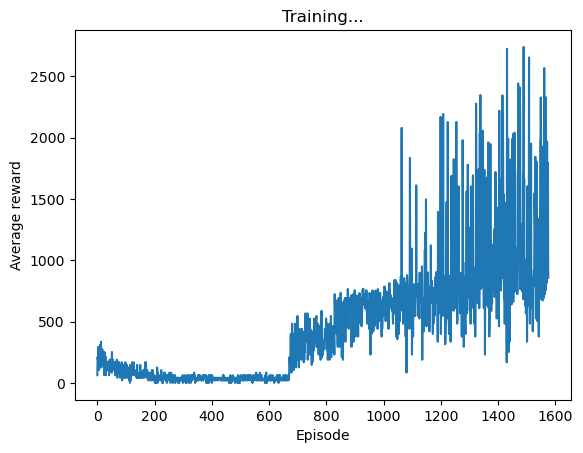

In [14]:
plot_results(avg_reward_list)

In [15]:
import dill
dill.dump_session('assault.db')

In [16]:
torch.save(target_network.state_dict(), "assault_target_network.pt")

In [ ]:
import dill
dill.load_session("assault.db")

In [ ]:
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk(): # Thunk is "a piece of code that does some delayed work"
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, video_folder=f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        """
        Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.

        :param env: Environment to wrap
        :param noop_max: Maximum value of no-ops to run
        """
        env = NoopResetEnv(env, noop_max=30) 
        """
        Return only every ``skip``-th frame (frameskipping)
        and return the max between the two last frames.

        :param env: Environment to wrap
        :param skip: Number of ``skip``-th frame
            The same action will be taken ``skip`` times.
        """
        env = MaxAndSkipEnv(env, skip=4)
        """
        Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.

        :param env: Environment to wrap
        """
        env = EpisodicLifeEnv(env)
        """
        Take action on reset for environments that are fixed until firing.

        :param env: Environment to wrap
        """
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        """
        Clip the reward to {+1, 0, -1} by its sign.

        :param env: Environment to wrap
        """
        env = ClipRewardEnv(env)
        # Resize the observation into 84 x 84 image
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        # Make RGB image into grayscale image
        env = gym.wrappers.GrayScaleObservation(env)
        # Stack every 4 frames together
        env = gym.wrappers.FrameStack(env, 4)
        env.action_space.seed(seed)
        return env
    return thunk

In [17]:
args.capture_video = True
print(args.capture_video)

True


In [19]:
import gymnasium as gym

# Experience play using the learned q_net

envs = gym.vector.SyncVectorEnv(
    [make_env(args.env_id, args.seed + i, i, args.capture_video, '1') for i in range(args.num_envs)]
)
# env.metadata['render_fps'] = 60
observations, info = envs.reset(seed=args.seed)
# obs_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

for _ in range(1000):
    # state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    q_values = target_network(torch.Tensor(observations).to(device))
    actions = torch.argmax(q_values, dim=1).cpu().numpy()
    # action = env.action_space.sample() #target_net(state).max(1).indices.view(1, 1)
    observations, rewards, terminateds, truncateds, infos = envs.step(actions)
    # print(observation)
    # if terminateds or truncateds:
    #     observations, infos = envs.reset()
envs.close()

Moviepy - Building video c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-0.mp4


Moviepy - Building video c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\choto\OneDrive - Kansas State University\PhD Projects\Reinforcement Learning\precision_ag_code\videos\1\rl-video-episode-1.mp4


In [ ]:
envs.close()